<a href="https://colab.research.google.com/github/bungerz/firstDataAnalysis/blob/master/Hackathon_AI_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [1]:
!unzip HDLTex\ dataset-20250508.zip -d HDLTex
!unzip fMRI\ dataset-20250508.zip -d fMRI

!pip install wfdb
!pip install pandas==2.2.2

Archive:  HDLTex dataset-20250508.zip
  inflating: HDLTex/Dictionary.txt   
  inflating: HDLTex/HLDTex.pdf       
  inflating: HDLTex/ReadMe.txt       
  inflating: HDLTex/Meta-data/Data.xlsx  
  inflating: HDLTex/WOS11967/X.txt   
  inflating: HDLTex/WOS11967/Y.txt   
  inflating: HDLTex/WOS11967/YL1.txt  
  inflating: HDLTex/WOS11967/YL2.txt  
  inflating: HDLTex/WOS46985/X.txt   
  inflating: HDLTex/WOS46985/Y.txt   
  inflating: HDLTex/WOS46985/YL1.txt  
  inflating: HDLTex/WOS46985/YL2.txt  
  inflating: HDLTex/WOS5736/X.txt    
  inflating: HDLTex/WOS5736/Y.txt    
  inflating: HDLTex/WOS5736/YL1.txt  
  inflating: HDLTex/WOS5736/YL2.txt  
Archive:  fMRI dataset-20250508.zip
  inflating: fMRI/centralities_with_labels.csv  
  inflating: fMRI/Table_ADNI.csv     
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 130.6 

In [95]:
#!wget -r -np -nH --cut-dirs=4 -R "index.html*" -P physionet https://physionet.org/files/challenge-2020/1.0.2/training/cpsc_2018/
import kagglehub
# Download latest version
physionet_path = kagglehub.dataset_download("bjoernjostein/china-physiological-signal-challenge-in-2018")
physionet_path += "/Training_WFDB"
print("Path to dataset files:", physionet_path)
# Download latest version
ecg_snomed_path = kagglehub.dataset_download("bjoernjostein/physionet-snomed-mappings")
print("Path to dataset files:", ecg_snomed_path)

Path to dataset files: /kaggle/input/china-physiological-signal-challenge-in-2018/Training_WFDB
Path to dataset files: /kaggle/input/physionet-snomed-mappings


The disease associated with each patient is coded in snomed. Snomed is a terminology to represent clinical related concepts. You can search each term in this [browser](https://browser.ihtsdotools.org/?perspective=full&conceptId1=404684003&edition=MAIN/2023-03-31&release=&languages=en) to get more information about the disease corresponding to a given code.

In [96]:
dx_dict = {
    "426783006": "SNR",  # Normal sinus rhythm
    "164889003": "AF",  # Atrial fibrillation
    "270492004": "IAVB",  # First-degree atrioventricular block
    "164909002": "LBBB",  # Left bundle branch block
    "713427006": "RBBB",  # Complete right bundle branch block
    "59118001": "RBBB",  # Right bundle branch block
    "284470004": "PAC",  # Premature atrial contraction
    "63593006": "PAC",  # Supraventricular premature beats
    "164884008": "PVC",  # Ventricular ectopics
    "429622005": "STD",  # ST-segment depression
    "164931005": "STE",  # ST-segment elevation
}

In [97]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
import wfdb
import os

# Quick exploration

## fmri

In [98]:
fmri_adni = pl.read_csv('fMRI/Table_ADNI.csv')
fmri_centrality = pl.read_csv('fMRI/centralities_with_labels.csv')
# fmri_adni_subject = fmri_adni.filter((pl.col('Age')==63) & (pl.col('Sex')=='F'))
# fmri_adni_peers = fmri_adni.filter((pl.col('Age') > 55) & (pl.col('Age') <  70) & (pl.col('Sex')=='F'))
# display(fmri_adni_subject)
# display(fmri_adni_peers)
# groups is illness, subgroups of neurodegenerative disease
# MCI: mild cognitive imperment
fmri_adni

Subject,Group,RID,Sex,Code_sex,Age,APGEN1,APGEN2,PTEDUCAT,MMSE,CDR,NPI,GDSCALE,E4,E2,E3
str,str,i64,str,i64,i64,i64,i64,i64,i64,f64,i64,i64,i64,i64,i64
"""037_S_0150""","""MCI""",150,"""M""",1,86,3,3,12,27,0.5,4,1,0,0,1
"""002_S_0413""","""CN""",413,"""F""",2,87,3,3,16,29,0.0,0,0,0,0,1
"""032_S_0677""","""CN""",677,"""M""",1,82,3,3,18,28,0.0,0,0,0,0,1
"""041_S_0679""","""MCI""",679,"""M""",1,74,3,3,18,29,0.5,3,0,0,0,1
"""068_S_0802""","""MCI""",802,"""F""",2,92,3,3,8,26,0.5,7,2,0,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""082_S_6690""","""AD""",6690,"""F""",2,68,3,4,14,20,1.0,4,1,1,0,0
"""041_S_6731""","""MCI""",6731,"""F""",2,67,3,4,20,27,0.5,1,3,1,0,0
"""011_S_4827""","""AD""",4827,"""M""",1,76,2,4,18,26,0.5,13,1,1,1,0


### PCA for fmri

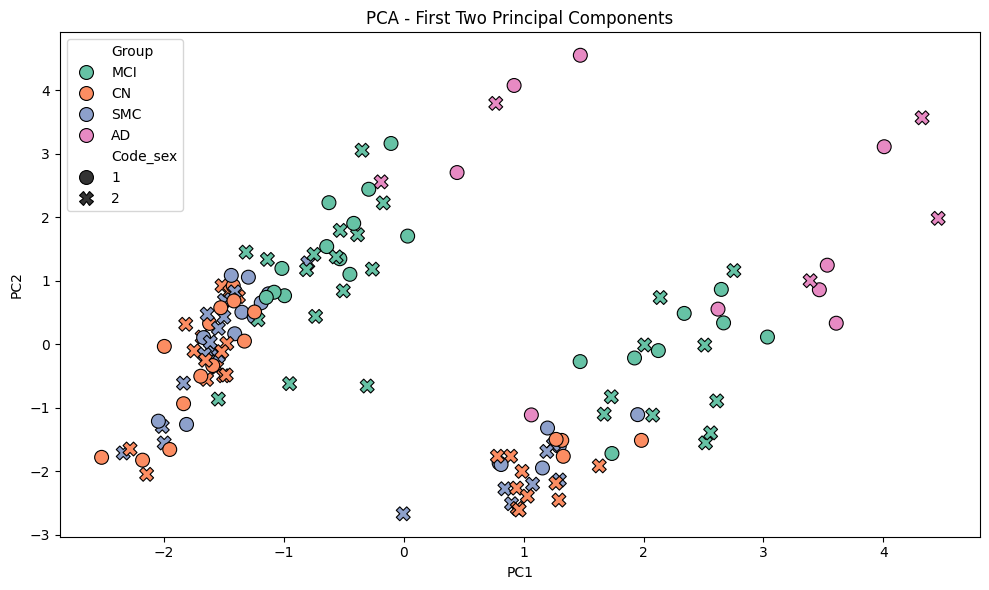

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Assuming fmri_adni is your original DataFrame
df_pandas = fmri_adni.to_pandas()

# Step 2: Select relevant columns for PCA (excluding Subject, Group, RID, Sex)
features = df_pandas.drop(columns=["Subject", "Group", "RID", "Sex"])

# Step 3: Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 4: Apply PCA to reduce to 2 components for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_scaled)

# Step 5: Create a DataFrame for the PCA results
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"])

# Step 6: Add Group and Code_sex for coloring and symbol purposes
pca_df["Group"] = df_pandas["Group"]
pca_df["Code_sex"] = df_pandas["Code_sex"]

# Step 7: Visualize the first two principal components with color by Group and symbol by Code_sex
plt.figure(figsize=(10, 6))

# Define a list of markers based on Code_sex (assuming Code_sex contains categorical values like 0 and 1)
markers = {0: 'o', 1: 's'}  # 'o' for male (Code_sex=0), 's' for female (Code_sex=1)

# Use sns.scatterplot with style parameter for different markers based on Code_sex
sns.scatterplot(
    data=pca_df,
    x="PC1",
    y="PC2",
    hue="Group",
    style="Code_sex",  # Map marker styles to Code_sex
    palette="Set2",    # Color palette for Group
    s=100,
    edgecolor='black'
)

plt.title('PCA - First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Show the plot
plt.tight_layout()
plt.show()

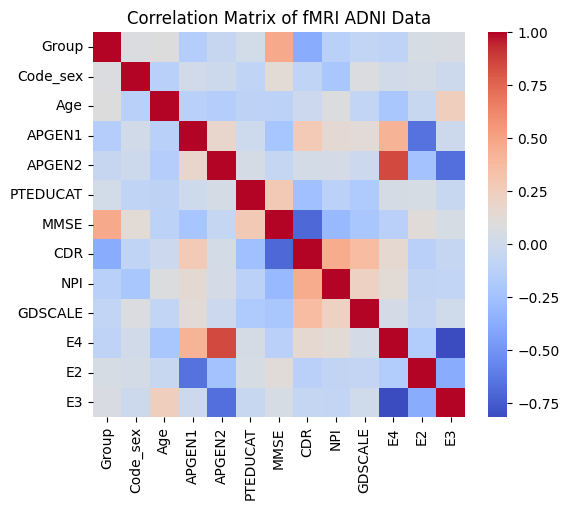

In [100]:
# prompt: from frmi_adni compute the correlation matrix, do not exclude the Group feature but put it as a numerical feature

# Assuming fmri_adni is your DataFrame from the previous code
# Convert 'Group' to numerical representation if it's categorical
# Example using Label Encoding
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_pandas['Group'] = le.fit_transform(df_pandas['Group'])

# Select all columns except 'Subject' and 'RID' for correlation calculation
correlation_matrix = df_pandas.drop(columns=["Subject", "RID",'Sex']).corr()

# Display the correlation matrix
# print(correlation_matrix)

# You can visualize the correlation matrix using a heatmap
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, cmap='coolwarm')
plt.title("Correlation Matrix of fMRI ADNI Data")
plt.show()


In [101]:
# case_data = fmri_centrality.filter(pl.col.Subject == fmri_adni_subject[0]['Subject']).drop("Subject")
# peers_data = fmri_centrality.filter(pl.col.Subject.is_in(fmri_adni_peers['Subject'].explode())).drop("Subject")
# fmri_centrality.describe()

In [102]:
# # Calculate Z-scores for the case patient
# peer_means = peers_data.mean()
# peer_stds = peers_data.std()
# z_scores = (case_data - peer_means) / peer_stds
# z_scores
# case_data.columns
# # Visualization
# z_df = z_scores.unpivot()
# plt.figure(figsize=(10, 5))
# sns.barplot(x="variable", y="value", data=z_df)
# plt.axhline(0, color="gray", linestyle="--")
# plt.title("fMRI Centrality Z-Scores for Case Patient")
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.savefig("fmri_zscores.png")
# plt.show()

## ECG

In [103]:
import glob
all_ecg_paths = glob.glob(os.path.join(physionet_path,'*.hea'))
ecg_patients = [path.split('/')[-1].split('.')[0].replace('A','HR0') for path in all_ecg_paths]
ecg_ref = pl.read_csv("reference.csv",null_values=['NaN'])
ecg_labels = pl.read_csv("labels.csv",null_values=['NaN'])
ecg_labels = ecg_labels.filter(pl.col.patient_id.is_in(ecg_patients))
ecg_ref = ecg_ref.filter(pl.col.patient_id.is_in(ecg_patients))
ecg_labels.group_by('set').agg(pl.col.SNR.count())
ecg_ref_63_F = ecg_ref.filter((pl.col.age==63) & (pl.col.sex=='Female'))
ecg_ref_63_F
# ecg_ref
# ecg_patients

patient_id,sample_rate,signal_len,age,sex,dx
str,i64,i64,i64,str,str
"""HR00259""",500,5000,63,"""Female""","""164861001,426783006"""
"""HR00443""",500,5000,63,"""Female""","""426783006"""
"""HR00449""",500,5000,63,"""Female""","""164890007"""
"""HR00571""",500,5000,63,"""Female""","""426783006,429622005,55930002"""
"""HR00629""",500,5000,63,"""Female""","""426783006"""
…,…,…,…,…,…
"""HR05932""",500,5000,63,"""Female""","""426783006"""
"""HR05949""",500,5000,63,"""Female""","""164861001,427084000,429622005,…"
"""HR06433""",500,5000,63,"""Female""","""164873001,39732003,426783006,4…"


quick print of one ECG

The signal has 11000 timesteps and 12 leads


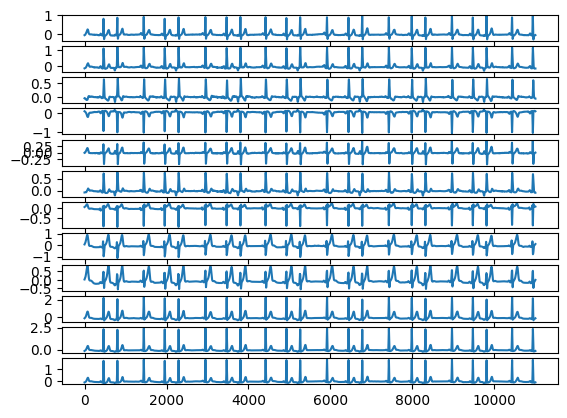

In [104]:
path_signal = os.path.join(physionet_path, "A0500" )
signal, metadata = wfdb.rdsamp(path_signal)
print(f"The signal has {signal.shape[0]} timesteps and {signal.shape[1]} leads")
fig, axs = plt.subplots(signal.shape[1])
for idx in range(signal.shape[1]):
    axs[idx].plot(signal[:,idx])
plt.show()

ecg Snomed mapping

In [105]:
snomed_csv_paths = glob.glob(os.path.join(ecg_snomed_path,'**.csv'))
#glob.glob(os.path.join(an_ecg_path,'**/*.hea'))

import glob
ecg_snomed0 = pl.read_csv(snomed_csv_paths[0],separator=';').select(["Dx",pl.col("SNOMED CT Code").cast(pl.String),"Abbreviation","CPSC"])
ecg_snomed1 = pl.read_csv(snomed_csv_paths[1],separator=';').select(["Dx",pl.col("SNOMED CT Code").cast(pl.String),"Abbreviation","CPSC"])
# ecg_snomed0 = ecg_snomed0.filter(pl.col.CPSC != 0)
# ecg_snomed1 = ecg_snomed1.filter(pl.col.CPSC != 0)

ecg_snomed = pl.concat([ecg_snomed0,ecg_snomed1])
ecg_snomed

Dx,SNOMED CT Code,Abbreviation,CPSC
str,str,str,i64
"""1st degree av block""","""270492004""","""IAVB""",722
"""atrial fibrillation""","""164889003""","""AF""",1221
"""atrial flutter""","""164890007""","""AFL""",0
"""bradycardia""","""426627000""","""Brady""",0
"""complete right bundle branch b…","""713427006""","""CRBBB""",0
…,…,…,…
"""ventricular pre excitation""","""195060002""","""VPEx""",0
"""ventricular tachycardia""","""164895002""","""VTach""",0
"""ventricular trigeminy""","""251180001""","""VTrig""",0


# Training Models

## ECG

patient to disease list

In [106]:
def assign_random_age(age):
    if age >= 300:
        # Generate a random value between 89 and 100 using an exponential distribution
        random_age = np.random.exponential(scale=5) + 89
        # Ensure that the random age is in the desired range
        return min(max(int(random_age), 89), 100)
    return age

# Step 1: Split the 'dx' column in `ecg_ref` into lists of codes
ecg_ref_split = ecg_ref.with_columns(
    pl.col("dx").str.split(",").alias("dx_split")
)

# Step 2: Explode the list of disease codes into separate rows
ecg_ref_exploded = ecg_ref_split.explode("dx_split")

# Step 3: Perform a left join to map the disease codes to disease names
joined_df = ecg_ref_exploded.join(ecg_snomed, left_on="dx_split", right_on="SNOMED CT Code", how="left")

# Step 4: Group back by 'patient_id' to get the disease names for each patient
final_df = joined_df.group_by("patient_id").agg(
    pl.col("Dx").alias("disease_names"),
    pl.col("age").first(),
    pl.col("sex").first(),
).with_columns(
    pl.col("age").map_elements(assign_random_age).alias("age")
)
final_df

<ipython-input-106-885e62e28e05>:25: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  ).with_columns(


patient_id,disease_names,age,sex
str,list[str],i64,str
"""HR01522""","[""left ventricular hypertrophy"", ""sinus rhythm""]",73,"""Male"""
"""HR06418""","[""sinus rhythm""]",86,"""Female"""
"""HR01955""","[""myocardial infarction"", ""left axis deviation"", … ""nonspecific intraventricular conduction disorder""]",71,"""Female"""
"""HR04929""","[""myocardial infarction"", ""abnormal QRS"", … ""complete right bundle branch block""]",54,"""Female"""
"""HR05233""","[""left axis deviation"", ""sinus bradycardia"", ""sinus rhythm""]",64,"""Male"""
…,…,…,…
"""HR05697""","[""sinus bradycardia"", ""sinus rhythm""]",78,"""Male"""
"""HR06131""","[""sinus rhythm""]",23,"""Male"""
"""HR06659""","[""sinus rhythm""]",84,"""Male"""


### ECG: Disease by Age

<ipython-input-107-609bbae52417>:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_exploded, x="age", multiple="stack", palette='Set2', bins=30) #hue="disease_names"


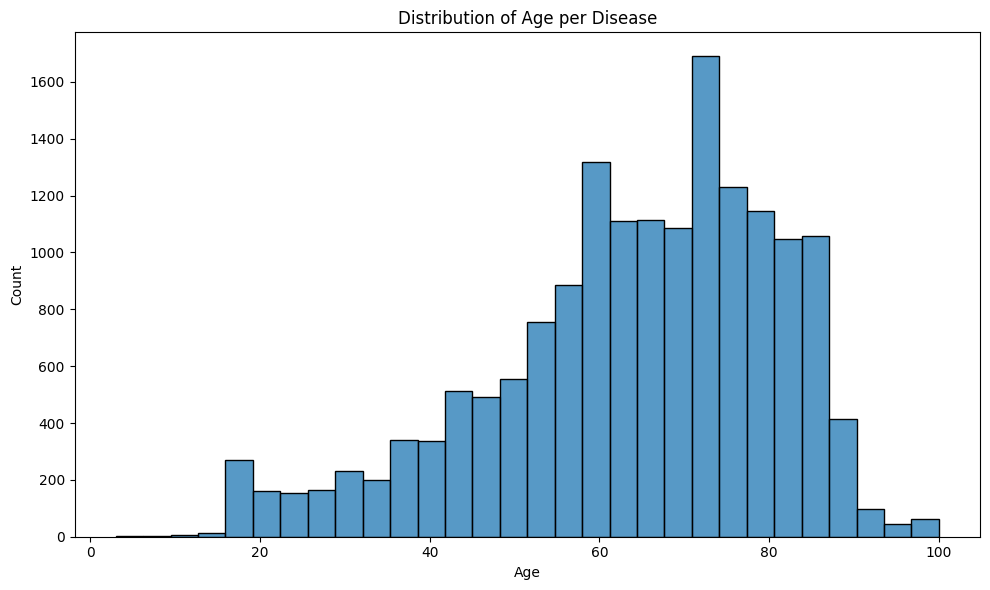

In [107]:

# Step 3: Explode the disease_names list into separate rows
df_exploded = final_df.to_pandas().explode('disease_names')

# Step 4: Reset the index to avoid index duplication issues
df_exploded = df_exploded.reset_index(drop=True)

# Step 5: Plot the distribution of Age per Disease
plt.figure(figsize=(10, 6))

# Plot histograms for Age per disease
sns.histplot(data=df_exploded, x="age", multiple="stack", palette='Set2', bins=30) #hue="disease_names"

# Set the plot title and labels
plt.title('Distribution of Age per Disease')
plt.xlabel('Age')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()


adding multihot

In [108]:
import polars as pl
import numpy as np

# Assuming `final_df` is your DataFrame with the `patient_id` and `disease_names`

# Step 1: Get the list of unique diseases and create a dictionary that maps disease names to indices
unique_diseases = set([disease for disease_list in final_df["disease_names"] for disease in disease_list])
disease_to_index = {disease: idx for idx, disease in enumerate(sorted(unique_diseases))}

# Print disease to index mapping for reference
print(disease_to_index)

# Step 2: Generate Multi-Hot Encoding for each patient
def generate_multi_hot(disease_names, disease_to_index):
    # Create a binary vector (multi-hot encoding)
    multi_hot = np.zeros(len(disease_to_index), dtype=int)
    for disease in disease_names:
        if disease in disease_to_index:
            multi_hot[disease_to_index[disease]] = 1
    return multi_hot

# Step 3: Apply the multi-hot encoding to the 'disease_names' column
multi_hot_vectors = [
    generate_multi_hot(disease_names, disease_to_index)
    for disease_names in final_df["disease_names"]
]

# Step 4: Add the multi-hot encoding column to the DataFrame
final_df = final_df.with_columns(
    pl.DataFrame({"multi_hot": multi_hot_vectors})
)

final_df

{'1st degree av block': 0, '2nd degree av block': 1, 'abnormal QRS': 2, 'anterior ischemia': 3, 'anterior myocardial infarction': 4, 'atrial fibrillation': 5, 'atrial flutter': 6, 'complete heart block': 7, 'complete right bundle branch block': 8, 'incomplete left bundle branch block': 9, 'incomplete right bundle branch block': 10, 'indeterminate cardiac axis': 11, 'inferior ischaemia': 12, 'lateral ischaemia': 13, 'left anterior fascicular block': 14, 'left atrial enlargement': 15, 'left axis deviation': 16, 'left bundle branch block': 17, 'left posterior fascicular block': 18, 'left ventricular hypertrophy': 19, 'low qrs voltages': 20, 'myocardial infarction': 21, 'myocardial ischemia': 22, 'nonspecific intraventricular conduction disorder': 23, 'nonspecific st t abnormality': 24, 'pacing rhythm': 25, 'paroxysmal supraventricular tachycardia': 26, 'premature atrial contraction': 27, 'prolonged pr interval': 28, 'prolonged qt interval': 29, 'qwave abnormal': 30, 'right atrial hypertro

patient_id,disease_names,age,sex,multi_hot
str,list[str],i64,str,"array[i64, 50]"
"""HR01522""","[""left ventricular hypertrophy"", ""sinus rhythm""]",73,"""Male""","[0, 0, … 0]"
"""HR06418""","[""sinus rhythm""]",86,"""Female""","[0, 0, … 0]"
"""HR01955""","[""myocardial infarction"", ""left axis deviation"", … ""nonspecific intraventricular conduction disorder""]",71,"""Female""","[0, 0, … 0]"
"""HR04929""","[""myocardial infarction"", ""abnormal QRS"", … ""complete right bundle branch block""]",54,"""Female""","[0, 0, … 0]"
"""HR05233""","[""left axis deviation"", ""sinus bradycardia"", ""sinus rhythm""]",64,"""Male""","[0, 0, … 0]"
…,…,…,…,…
"""HR05697""","[""sinus bradycardia"", ""sinus rhythm""]",78,"""Male""","[0, 0, … 0]"
"""HR06131""","[""sinus rhythm""]",23,"""Male""","[0, 0, … 0]"
"""HR06659""","[""sinus rhythm""]",84,"""Male""","[0, 0, … 0]"


In [110]:
# Step 1: Load ECG Data for each patient
X = np.mean(np.stack([np.array(wfdb.rdrecord(f'{fname.replace(".hea","")}').p_signal[:1000]) for fname in all_ecg_paths]),axis=2)
X = (X - np.mean(X)) / np.std(X)
# Step 2: Prepare multi-hot encoded labels
y = np.array([patient for patient in final_df["multi_hot"]])

# Check the shape of X and y
print("Shape of ECG data X:", X.shape)  # Should be (num_samples, 1000, num_channels)
print("Shape of labels y:", y.shape)    # Should be (num_samples, num_diseases)


Shape of ECG data X: (6877, 1000)
Shape of labels y: (6877, 50)


In [111]:
import numpy as np
import wfdb
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score

# Load all 12 leads (assuming 1000 time steps)
X = np.stack([
    wfdb.rdrecord(f'{fname.replace(".hea","")}').p_signal[:1000, :]  # shape: (1000, 12)
    for fname in all_ecg_paths
])

# Normalize per sample, per channel
X = (X - np.mean(X, axis=1, keepdims=True)) / (np.std(X, axis=1, keepdims=True) + 1e-8)

# Step 2: Prepare multi-hot encoded labels
y = np.array([patient for patient in final_df["multi_hot"]], dtype=np.float32)

# Check the shape of X and y
print("Shape of ECG data X:", X.shape)  # Should be (num_samples, 1000, 12)
print("Shape of labels y:", y.shape)    # Should be (num_samples, num_diseases)

# Step 3: Split the dataset into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define model parameters
num_timesteps = X.shape[1]  # 1000 time steps
num_channels = X.shape[2]   # 12 channels
num_classes = y.shape[1]    # number of diseases

model = Sequential([
    Input(shape=(num_timesteps, num_channels)),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

# Step 6: Compile the model with improved metrics
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Step 7: Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[EarlyStopping(patience=3, restore_best_weights=True)]
)

# Optional: Save the trained model
model.save("ecg_lstm_model.h5")

# Step 8: Evaluate with F1-score
y_pred = model.predict(X_val) > 0.5
print("F1-score (macro):", f1_score(y_val, y_pred, average='macro'))
print("F1-score (micro):", f1_score(y_val, y_pred, average='micro'))

Shape of ECG data X: (6877, 1000, 12)
Shape of labels y: (6877, 50)
Epoch 1/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - auc: 0.6740 - binary_accuracy: 0.8060 - loss: 0.4208 - val_auc: 0.8561 - val_binary_accuracy: 0.9662 - val_loss: 0.1455
Epoch 2/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - auc: 0.8467 - binary_accuracy: 0.9647 - loss: 0.1373 - val_auc: 0.8729 - val_binary_accuracy: 0.9662 - val_loss: 0.1257
Epoch 3/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 22s 75ms/step - auc: 0.8511 - binary_accuracy: 0.9659 - loss: 0.1343 - val_auc: 0.8749 - val_binary_accuracy: 0.9662 - val_loss: 0.1253
Epoch 4/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - auc: 0.8573 - binary_accuracy: 0.9650 - loss: 0.1347 - val_auc: 0.8746 - val_binary_accuracy: 0.9662 - val_loss: 0.1254
Epoch 5/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - auc: 0.8647 - binary_accuracy: 0.9661 - loss: 0.1293 - val_auc: 0.8775 - val_binary_accuracy: 0.9662 - val_loss: 0.1244
Epoch 6/20
172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/ste

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
F1-score (macro): 0.018407218517065515
F1-score (micro): 0.5024630541871922


In [112]:
# Evaluate on validation data
results = model.evaluate(X_val, y_val, batch_size=32)
print("Loss and metrics:", results)

print(dict(zip(model.metrics_names, results)))

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - auc: 0.8768 - binary_accuracy: 0.9662 - loss: 0.1243
Loss and metrics: [0.1244177371263504, 0.9662355184555054, 0.877488911151886]
{'loss': 0.1244177371263504, 'compile_metrics': 0.9662355184555054}


Plotting Training History

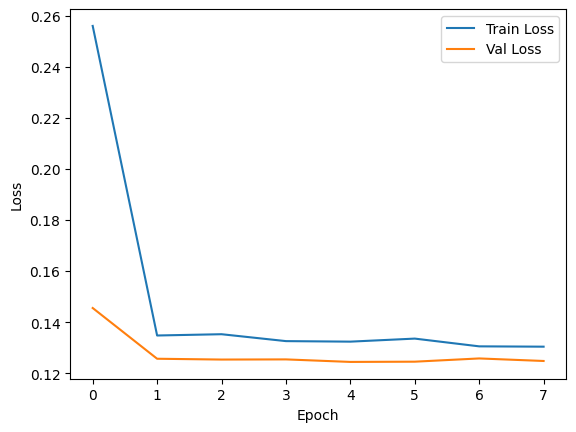

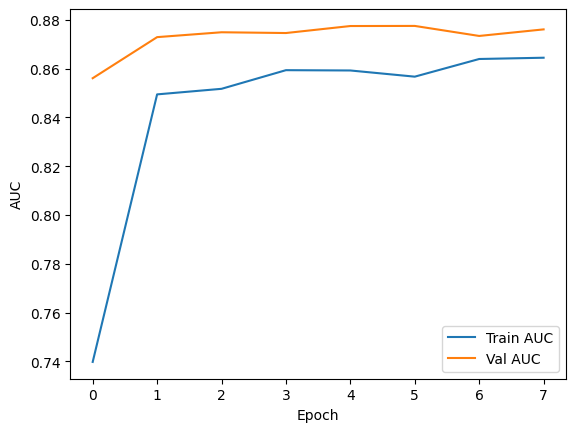

In [113]:
import matplotlib.pyplot as plt

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot AUC
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

In [114]:
ecg_paths_63_F = []
for patient_id in ecg_ref_63_F['patient_id'].to_list():
   ecg_paths_63_F.extend([path for path in all_ecg_paths if patient_id.replace('HR0',"") in path])

                                              ecg_path  \
5    /kaggle/input/china-physiological-signal-chall...   
133  /kaggle/input/china-physiological-signal-chall...   
245  /kaggle/input/china-physiological-signal-chall...   
66   /kaggle/input/china-physiological-signal-chall...   
512  /kaggle/input/china-physiological-signal-chall...   
..                                                 ...   
155  /kaggle/input/china-physiological-signal-chall...   
364  /kaggle/input/china-physiological-signal-chall...   
286  /kaggle/input/china-physiological-signal-chall...   
536  /kaggle/input/china-physiological-signal-chall...   
207  /kaggle/input/china-physiological-signal-chall...   

                                  disease  probability  
5                            sinus rhythm     0.852511  
133                          sinus rhythm     0.848756  
245                          sinus rhythm     0.846550  
66                           sinus rhythm     0.846087  
512               

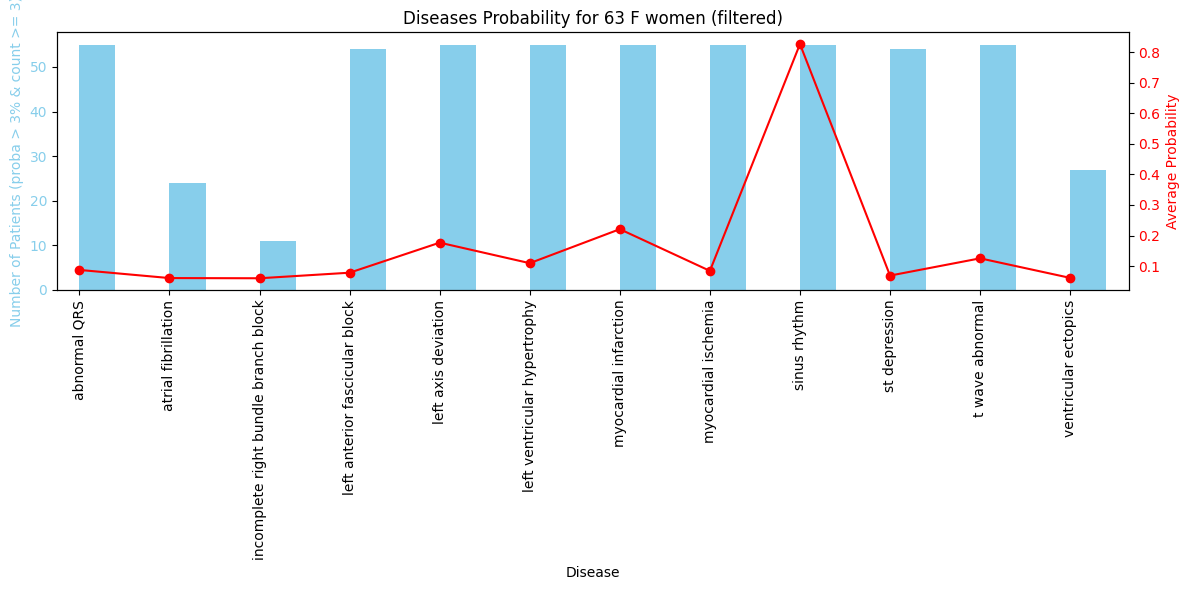

In [115]:
# Assume:
# - model is your trained Keras model
# - disease_to_index is your {disease_name: index} mapping
# - final_df contains your patients and their ECG file paths
# - all_ecg_paths is a list of ECG file paths in the same order as final_df


# Set your minimum count threshold
min_count = len(ecg_paths_63_F)/10  # Change as needed
min_proba = 0.06

# Get the reverse mapping for index to disease name
index_to_disease = {idx: disease for disease, idx in disease_to_index.items()}

all_top_diseases = []
all_top_probs = []
all_patient_paths = []

for ecg_path in ecg_paths_63_F:
    ecg = wfdb.rdrecord(ecg_path.replace(".hea", "")).p_signal[:1000, :]
    ecg = (ecg - np.mean(ecg, axis=0, keepdims=True)) / (np.std(ecg, axis=0, keepdims=True) + 1e-8)
    ecg = ecg[np.newaxis, ...]
    probs = model.predict(ecg,verbose='No')[0]
    # Get all diseases with probability > 3%
    indices = np.where(probs > min_proba)[0]
    for idx in indices:
        all_patient_paths.append(ecg_path)
        all_top_diseases.append(index_to_disease[idx])
        all_top_probs.append(probs[idx])

# Create a DataFrame for all diseases with proba > 3%
df_all = pd.DataFrame({
    "ecg_path": all_patient_paths,
    "disease": all_top_diseases,
    "probability": all_top_probs
})

print(df_all.sort_values('probability', ascending=False))


# Filter diseases by count
disease_counts = df_all['disease'].value_counts()
diseases_to_keep = disease_counts[disease_counts >= min_count].index

# Filter df_all to keep only those diseases
df_filtered = df_all[df_all['disease'].isin(diseases_to_keep)]

# Recompute counts and means on filtered data
disease_counts_filtered = df_filtered['disease'].value_counts().sort_index()
disease_means_filtered = df_filtered.groupby('disease')['probability'].mean().sort_index()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar plot for number of patients
disease_counts_filtered.plot(kind='bar', color='skyblue', ax=ax1, position=0, width=0.4)
ax1.set_ylabel('Number of Patients (proba > 3% & count >= 3)', color='skyblue')
ax1.set_xlabel('Disease')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_title('Diseases Probability for 63 F women (filtered)')

# Line plot for average probability
ax2 = ax1.twinx()
disease_means_filtered.plot(kind='line', color='red', marker='o', ax=ax2)
ax2.set_ylabel('Average Probability', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.show()

### PCA on LSTM Output plot is weird



/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_32']
Received: inputs=Tensor(shape=(32, 1000, 12))
  warnings.warn(msg)


43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step


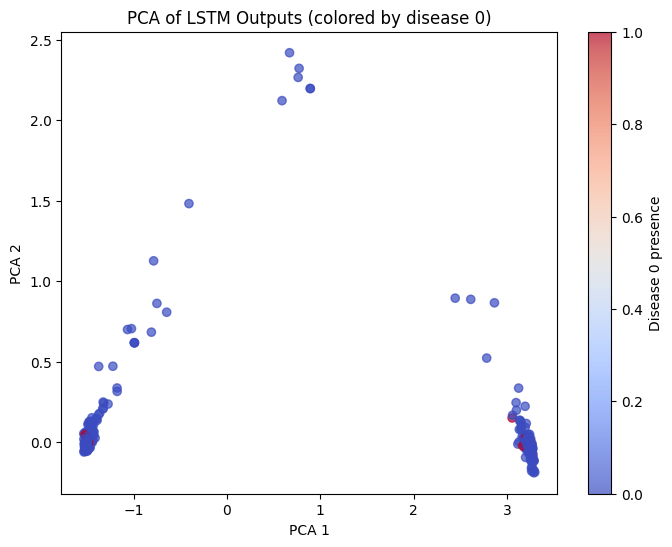

In [149]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

# Define a new model to extract the output of the last LSTM layer. search the lstm layer by its type

intermediate_layer_model = Model(inputs=model.inputs, outputs=model.get_layer(index=2).output)

# Get the output of the last LSTM layer
lstm_outputs = intermediate_layer_model.predict(X_val)  # shape: (num_samples, 32)

# Run PCA
pca = PCA(n_components=2)
lstm_pca = pca.fit_transform(lstm_outputs)

# Plot, coloring by presence/absence of a disease (e.g., disease 0)
plt.figure(figsize=(8, 6))
plt.scatter(lstm_pca[:, 0], lstm_pca[:, 1], c=y_val[:, 0], cmap='coolwarm', alpha=0.7)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title('PCA of LSTM Outputs (colored by disease 0)')
plt.colorbar(label='Disease 0 presence')
plt.show()

## fMRI

### Disease by Age (nice one Mina :) )

In [ ]:
# Step 3: Plot the distribution of Age per Group using histplot
plt.figure(figsize=(10, 6))

# Use histplot with a categorical `hue` to differentiate groups
sns.histplot(data=fmri_adni, x="Age", hue="Group", kde=True, multiple="stack", palette='Set2', bins=30)

# Optional: You can use kde=False to remove the KDE (Kernel Density Estimate) curve
# sns.histplot(data=df_pandas, x="Age", hue="Group", kde=False, multiple="stack", palette='Set2', bins=30)

# Set the plot title and labels
plt.title('Distribution of Age per Group')
plt.xlabel('Age')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Step 3: Plot the distribution of Age per Group using histplot
plt.figure(figsize=(10, 6))

# Use histplot with a categorical `hue` to differentiate groups
sns.histplot(data=fmri_adni, x="Age", hue="Group", kde=True, multiple="stack", palette='Set2', bins=30)

# Optional: You can use kde=False to remove the KDE (Kernel Density Estimate) curve
# sns.histplot(data=df_pandas, x="Age", hue="Group", kde=False, multiple="stack", palette='Set2', bins=30)

# Set the plot title and labels
plt.title('Distribution of Age per Group')
plt.xlabel('Age')
plt.ylabel('Count')

# Show the plot
plt.tight_layout()
plt.show()